In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

most_recent_date = session.query(Measurement).order_by(Measurement.date.desc()).limit(5)


for the_date in most_recent_date:
    recent_date = the_date.date

#print(the_date.date)

recent_date = dt.datetime.strptime(recent_date, "%Y-%m-%d")

recent_date

datetime.datetime(2017, 8, 22, 0, 0)

In [14]:
# Calculate the date 1 year ago from the last data point in the database

past_year = recent_date - dt.timedelta(days=365)

past_year

datetime.datetime(2016, 8, 22, 0, 0)

In [15]:
# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= past_year). order_by(Measurement.date).all()

#prcp_data

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column

Data_Frame = pd.DataFrame(prcp_data).dropna()
#Data_Frame

In [17]:
# Sort the dataframe by date
Data_Frame['date'] = pd.to_datetime(Data_Frame['date'])
#Data_Frame

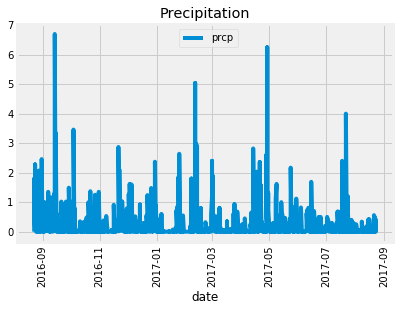

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(Data_Frame['date'],Data_Frame['prcp'])
plt.title('Precipitation')
plt.xlabel('date')
plt.xticks(rotation = '90')
plt.legend(bbox_to_anchor=(0.6, 1.00))

plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Data_Frame.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
stations_amount = session.query(Measurement.station).distinct().count()
print(f' There are a total of {stations_amount} stations.')



 There are a total of 9 stations.


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station = pd.DataFrame(session.query(Measurement.station, func.count(Measurement.station).label('count')).\
                      group_by(Measurement.station).\
                      order_by('count DESC').all(),columns=["Station", "No. of Measurements"])
station

,Station,No. of Measurements
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

Active_Station = session.query(Measurement.station,
                              func.count(Measurement.station).label('count')).\
                              group_by(Measurement.station).\
                              order_by('count DESC').limit(1)[0][0]

Temp_level = [func.min(Measurement.tobs),
              func.avg(Measurement.tobs),
              func.max(Measurement.tobs)]

session.query(*Temp_level).filter(Measurement.station==Active_Station).all()


[(54.0, 71.66378066378067, 85.0)]

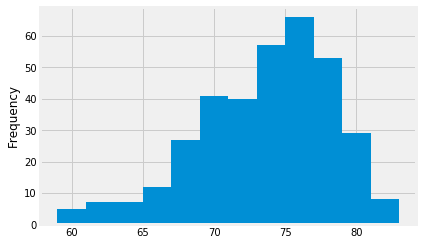

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_observations = session.query(Measurement.tobs).\
                                 filter(Measurement.station==Active_Station).\
                                 filter(Measurement.date >= past_year).\
                                 order_by(Measurement.date.desc()).all()

x = [x[0] for x in most_observations]

plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.show()

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

past_temps = (calc_temps('2017-02-28', '2017-03-05'))
past_temps

[(64.0, 72.02777777777777, 78.0)]

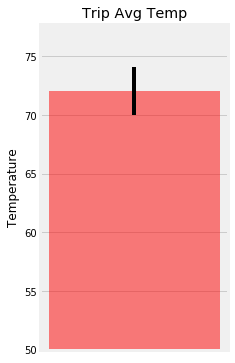

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

lower = past_temps[0][1] - past_temps[0][0]
upper = past_temps[0][2] - past_temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, past_temps[0][1], yerr=[upper-lower], color='red', alpha=0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temperature')
plt.ylim(50)

plt.show()

In [29]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def rainfall(start_date, end_date):
    return session.query(Measurement.station, 
                         Measurement.prcp.label('rainfall'),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                         group_by(Measurement.station).\
                         join(Station, Measurement.station == Station.station).\
                         filter(Measurement.date >= start_date).\
                         filter(Measurement.date <= end_date).\
                         order_by('rainfall DESC').all()

rainfall('2017-02-28', '2017-03-05')

[('USC00516128', 0.58, 21.3331, -157.8025, 152.4),
 ('USC00513117', 0.16, 21.4234, -157.8015, 14.6),
 ('USC00514830', 0.04, 21.5213, -157.8374, 7.0),
 ('USC00519281', 0.04, 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0, 21.33556, -157.71139, 19.5),
 ('USC00517948', None, 21.3934, -157.9751, 11.9)]